#### - Обучить полносвязную модель на MNIST
#### - Обучить глубокую сверточную сеть на MNIST

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

device = ("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])


train_set = datasets.MNIST('/files/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('/files/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

C:\Users\Katya\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [4]:
example_data.shape

torch.Size([64, 1, 28, 28])

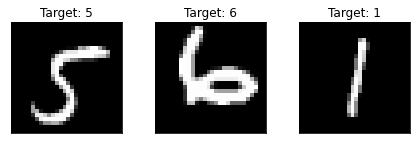

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Target: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [8]:
class FC_Network(nn.Module):

    def __init__(self):
        super(FC_Network, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [9]:
model = FC_Network()
model.to(device)

FC_Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [13]:
epochs = 21
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_test = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    total = 0
    
    # train
    for idx, (image, label) in enumerate(train_loader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
                
    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # test
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(test_loader):

        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_test = total / len(test_set)
    accuracy_total_test.append(accuracy_test)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
          print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_test))

Epoch: 0/21   Training loss: 0.5831   Testing loss: 0.2930   Train accuracy: 0.8284   Test accuracy: 0.9152  
Epoch: 5/21   Training loss: 0.3099   Testing loss: 0.1652   Train accuracy: 0.9169   Test accuracy: 0.9519  
Epoch: 10/21   Training loss: 0.2289   Testing loss: 0.1245   Train accuracy: 0.9400   Test accuracy: 0.9655  
Epoch: 15/21   Training loss: 0.1860   Testing loss: 0.1050   Train accuracy: 0.9514   Test accuracy: 0.9708  
Epoch: 20/21   Training loss: 0.1598   Testing loss: 0.0964   Train accuracy: 0.9584   Test accuracy: 0.9736  


In [14]:
images, labels = next(iter(test_loader))

with torch.no_grad():
    preds = model(images)

images_np = [i.mean(dim=0).cpu().numpy() for i in images]
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

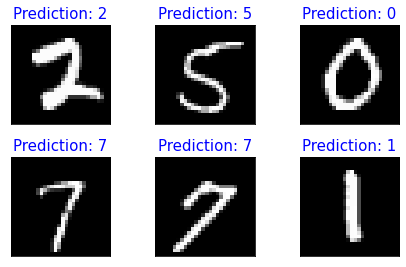

In [15]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(images_np[i], cmap='gray', interpolation='none')
    
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title("Prediction: {}".format(class_names[torch.max(preds[i], 0)[1]]), color=color, fontsize=15)

    plt.xticks([])
    plt.yticks([])

### - Обучить глубокую сверточную сеть на MNIST

In [16]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [18]:
model = CNN_Net()

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [21]:
epochs = 21
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):
   
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    
    total = 0
    
    # train
    for idx, (image, label) in enumerate(train_loader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1
                
    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # test
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(test_loader):

        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(test_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
          print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

<ipython-input-16-97547232b112>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 0/21   Training loss: 0.4994   Testing loss: 0.1754   Train accuracy: 0.8467   Test accuracy: 0.9487  
Epoch: 5/21   Training loss: 0.2391   Testing loss: 0.0786   Train accuracy: 0.9296   Test accuracy: 0.9752  
Epoch: 10/21   Training loss: 0.1898   Testing loss: 0.0597   Train accuracy: 0.9456   Test accuracy: 0.9802  
Epoch: 15/21   Training loss: 0.1659   Testing loss: 0.0518   Train accuracy: 0.9518   Test accuracy: 0.9834  
Epoch: 20/21   Training loss: 0.1545   Testing loss: 0.0460   Train accuracy: 0.9558   Test accuracy: 0.9849  


In [22]:
images, labels = next(iter(test_loader))

with torch.no_grad():
    preds = model(images)

images_np = [i.mean(dim=0).cpu().numpy() for i in images]
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

<ipython-input-16-97547232b112>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


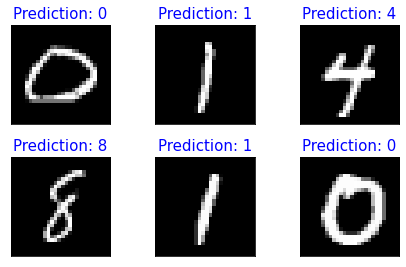

In [23]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(images_np[i], cmap='gray', interpolation='none')
    
    color = "blue" if labels[i] == torch.max(preds[i], 0)[1] else "red"
    plt.title("Prediction: {}".format(class_names[torch.max(preds[i], 0)[1]]), color=color, fontsize=15)

    plt.xticks([])
    plt.yticks([])